In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
from matplotlib import rcParams
from tqdm import tqdm
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from natsort import natsorted

import utilities as ut
from pyfcd.fcd import calculate_carriers, fcd

FRAME_PER_SECOND = 60
plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR

# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 26
rcParams['xtick.labelsize'] = 26
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

rcParams['savefig.bbox'] = 'tight'

In [2]:
#Obtenemos la calibración previamente realizada
calibrations = pd.read_csv('example_data/calibrations_fcd_dsk_60mm.csv')
# Use loc method to filter the data
PX_PER_MM = calibrations.loc[
    (calibrations['freq [Hz]'] == 10) & (calibrations['volt [Vpp]'] == 2),
    'calibration [px mm-1]'].iloc[0]

# amplitude_params = pd.read_csv('amplitude_parameters.csv')
# amplitude_params = amplitude_params[amplitude_params['freq [Hz]']==freq][amplitude_params['volt [Vpp]']==volt]
# y0 = amplitude_params.y_start.iloc[0]
# m = amplitude_params.angle.iloc[0]
# i_frame = amplitude_params.i_frame.iloc[0].astype(int)

#Creamos el objecto de captura de video
vs = cv.VideoCapture(f'example_media/fcd/2V-10Hz-swimmer.mp4')

#Probamos la mascara y obtenemos también el frame de referencia para los carriers
mask = [110,600,100,1200] # ymin, ymax, xmin, xmax
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret:
        frame = ut.gris(frame[mask[0]:mask[1],mask[2]:mask[3],:])
        if i==0:
            ref_frame = frame
        i+=1
        cv.imshow('frame', frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

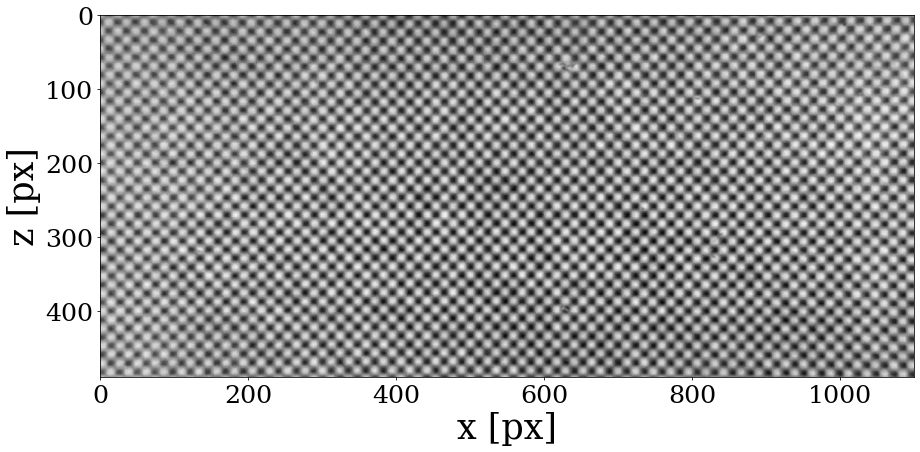

In [3]:
#Inspeccionamos el frame inicial
plt.imshow(ref_frame, cmap='gray')
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.show()

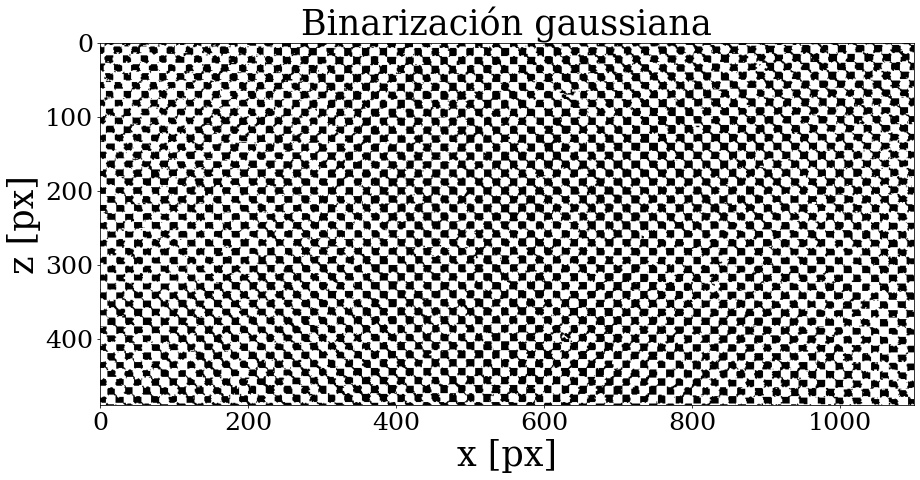

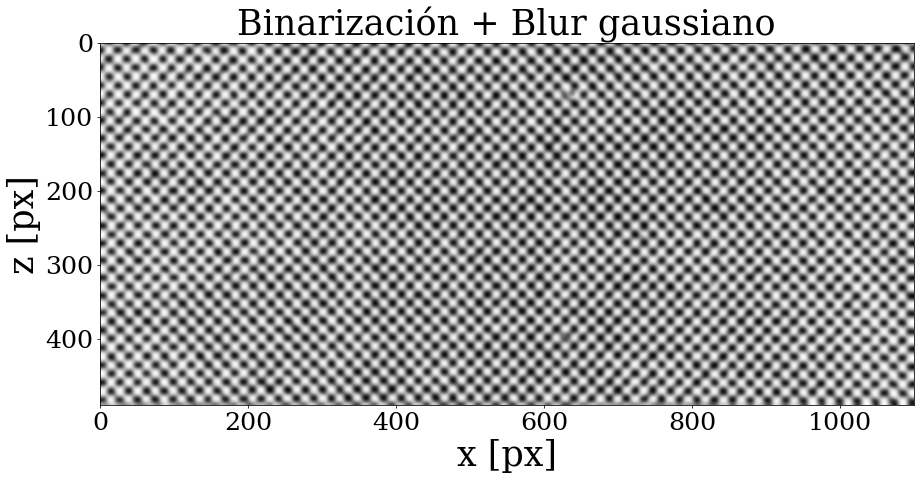

In [4]:
#El frame inicial está bien pero para binarizar tradicionalmente con un threshold la iluminación no es uniforme
im_binary = cv.adaptiveThreshold(ref_frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, blockSize=17, C=3)
im_blurred = cv.GaussianBlur(im_binary, (17,17), 3)

plt.figure()
plt.title('Binarización gaussiana')
plt.imshow(im_binary, cmap='gray')
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.show()

plt.figure()
plt.title('Binarización + Blur gaussiano')
im_blurred = cv.GaussianBlur(im_binary, (17,17), 3)
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.imshow(im_blurred, cmap='gray')

In [5]:
# Obtengo las mediciones de trayectoria de x e y para el video seleccionado
x,y,t,frame = ut.load_head_trayectories('example_data', '2V', '10Hz-dsk')

df_xy = pd.DataFrame().assign(x=x).assign(y=y)

# Selecciono el frame inicial y final en el que se empieza a medir la trayectoria de la cabeza
start = frame.iloc[0]
finish = frame.iloc[-1]

vs = cv.VideoCapture(f'example_media/fcd/2V-10Hz-swimmer.mp4')

# Calculo los vectores de número de onda para mi patrón de checkerboard
carriers = calculate_carriers(im_blurred, MM_PER_PX=(PX_PER_MM)**-1)

# Obtengo el mapa de deformaciones a partir de que se empieza a ver la cabeza y hasta que se va del frame
maps, (height, width) = ut.obtener_deformacion(vs,carriers,start = start,finish = finish, SHOW=True, mask = mask)

x_len = width
y_len = height

# Ajusto los bordes de mis vectores de posición de la cabeza en x según los límites de mi campo de deformaciones
df_xy = df_xy.loc[(df_xy.x<int(.9*x_len)) & (df_xy.x>int(.1*x_len))]
df_xy.x = (df_xy.x - int(.1*x_len))

# Actualizo los límites temporales de los campos de deformación para que sea consistente con la posición de la cabeza en x
maps = maps[df_xy.index[0]:df_xy.index[-1] + 1,:,:]

x,y = df_xy.x.to_numpy(),df_xy.y.to_numpy()

# Actualizo las variables x_len e y_len
x_len = maps[0].shape[1]
y_len = maps[0].shape[0]

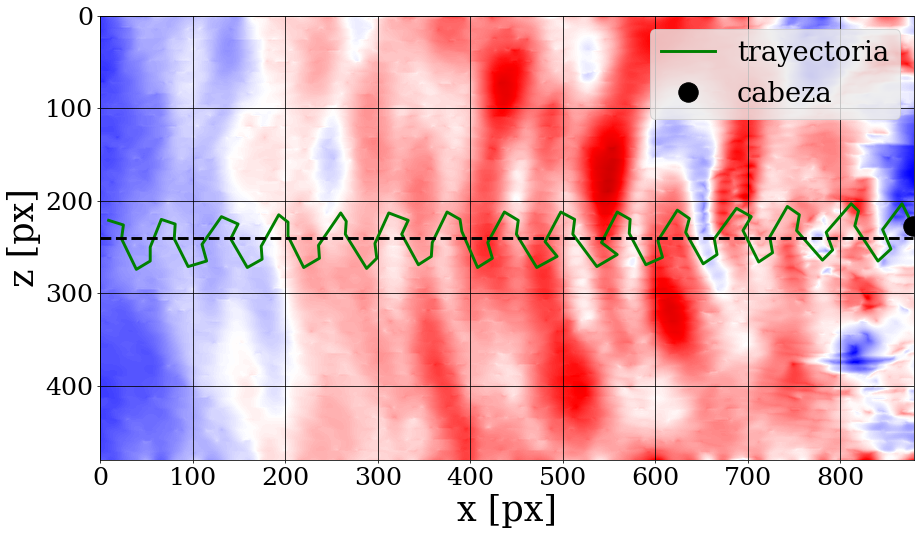

In [85]:
cmap, norm, max_height = ut.make_cmap_norm(maps)

# Seleccionamos nuestro frame de interes
i_frame = 0

# Vemos donde está la cabeza en ese momento
x_head, y_head = x[i_frame], y[i_frame]
xs = np.arange(0,x_head).astype(int)[::-1]

# Definimos la recta que identificamos como la trayectoria del nadador en x
y0 = 240
m = -np.tan(np.pi - np.pi*(1000/1000))
line_amp = (m*(np.arange(0,x_len) - x_head) + y0).astype(int)

# Ploteamos
plt.figure()
plt.plot(x,y, color='g', lw=3, label='trayectoria')
plt.plot(x_head,y_head,'o',ms=20,color='k', label='cabeza')
plt.imshow(maps[i_frame], aspect='equal', cmap=cmap, norm = norm)
plt.plot(np.arange(0,x_len), line_amp, ls='--', color='k', lw=3)

plt.ylabel('z [px]')
plt.xlabel('x [px]')
plt.grid()
plt.legend()
plt.show()

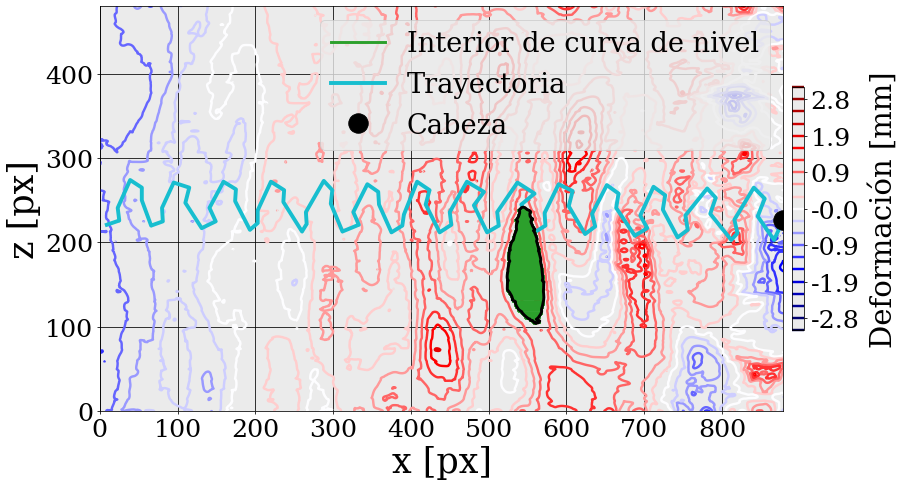

In [ ]:
# Este tamaño particular de figsize es solamente para mantener el aspect-ratio de los límites que definimos previamente
fig, ax = plt.subplots(figsize=(15,15*0.5011363636363636))
X,Y = np.meshgrid(np.arange(x_len),np.arange(y_len))

# Definimos los estratos de nuestras curvas de nivel y ploteamos los contornos
levels = np.arange(-max_height,1.1*max_height,.1*max_height)
cs = ax.contour(X,Y,maps[i_frame], levels,linewidths=2.5, cmap=cmap, norm = norm)

# Seleccionamos un area que es atravesada por el nadador. Este area se busca manualmente, no hay con que darle.
# cs.allsegs nos devuelve el contorno interpolado
xc,yc = cs.allsegs[14][12].T # countour for 2-10

# Transformamos el contorno a índices
y_edge = np.array([int(np.round(i)) for i in yc])
x_edge = np.array([int(np.round(i)) for i in xc])

# Creamos una meshgrid auxiliar
Xc,Yc = np.meshgrid(np.arange(x_len),np.arange(y_len))

# Ahora marcamos con "-1" todos los puntos (x,y) del meshgrid que se encuentren en el contorno seleccionado
for xe,ye in zip(x_edge,y_edge):
    Xc[ye,xe] = -1
    Yc[ye,xe] = -1

# Luego por cada recta horizontal definida por cada "y" del contorno debería haber dos puntos "x"
# Seleccionamos los índices "x" que se encuentran en el medio de esos dos puntos
# Este algoritmo es medio rudimentario pero funciona para las formas que nos importan
# Lo importante es agarrar una buena cantidad de puntos que sientan una amplitud parecida-
# para poder hacer luego una transformada de fourier promedio
xs_inside = np.zeros(len(set(y_edge)), dtype=object)
for i,ye in enumerate(set(y_edge)):
    borders = np.where(Xc[ye,:]==-1)[0]
    if len(borders)>1:
        xs_inside[i] = X[ye,borders[0]: borders[1] + 1]
    else:
        xs_inside[i] = []

# Definimos el colorbar
cbar = fig.colorbar(cs, pad=1e-2, shrink=0.6)
ticks = cbar.ax.get_yticks()
cbar.set_ticks(ticks)         # Ensure the ticks match
cbar.ax.set_yticklabels([f"{tick:.1f}" for tick in ticks])
cbar.ax.set_ylabel('Deformación [mm]',labelpad=10, fontsize=30)

# Ploteamos el contorno
ax.plot(xc,yc, color='k', lw=3, zorder=22)

# Por cada punto "y" dibujamos una linea horizontal entre los bordes seleccionados
for i,ye in enumerate(set(y_edge)):
    if len(xs_inside[i])>0:
        if i==0:
            ax.axhline(y = ye, xmin = xs_inside[i][0]/x_len, xmax= xs_inside[i][-1]/x_len, color='C2', lw=3, label = 'Interior de curva de nivel', zorder=21)
        else:
            ax.axhline(y = ye, xmin = xs_inside[i][0]/x_len, xmax= xs_inside[i][-1]/x_len, color='C2', lw=3, zorder=21)

# Ploteamos trayectoria y posición de la cabeza
plt.plot(x,y, '.-', color='C9', ms=1, label='Trayectoria',lw=4)
plt.plot(x_head,y_head,'o',ms=20,color='k', label='Cabeza')
plt.ylabel('z [px]')
plt.xlabel('x [px]')
plt.legend(loc='best')

plt.grid()
plt.show()

In [8]:
# Calculamos la transformada de fourier temporal para todo punto del espacio
s = len(maps)
map_fft = np.zeros((s//2 + 1,y_len,x_len)).astype(np.complex128)
fr = np.linspace(0,30,s//2 + 1)

for i in np.arange(y_len):
    for j in np.arange(x_len):
        map_fft[:,i,j] = np.fft.rfft(maps[:,i,j])

[]

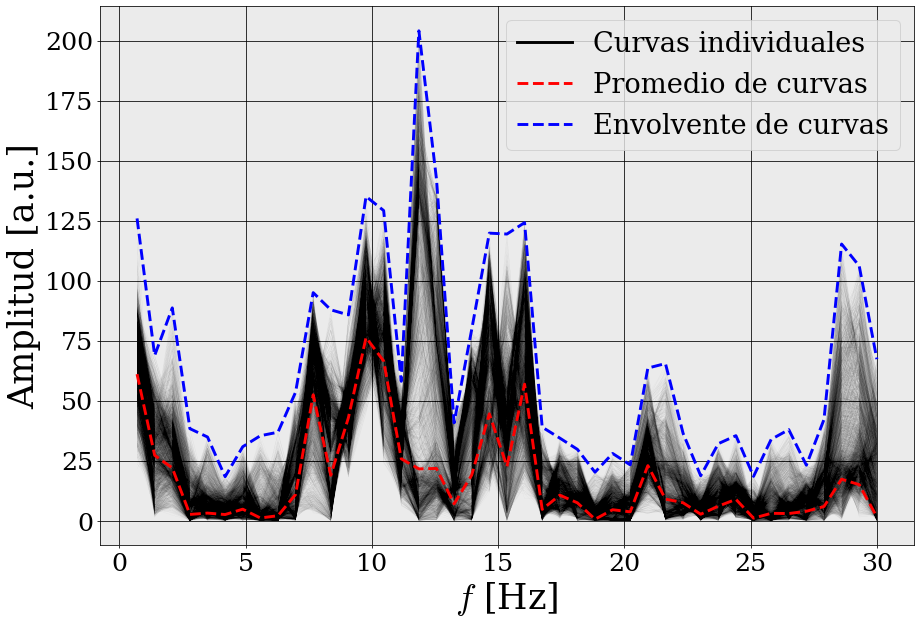

In [9]:
# Aca presentamos dos métodos para seleccionar los modos activados: por promedio de las fft o por envolvente de las fft.
# Despues de calcular cada método lo que uno debe hacer es ir campana por campana seleccionando sus bordes y su frecuencia principal
# Esas campanas, con sus bordes, son las que se van a utilizar luego para filtrar los modos fourier de nuestra medición.
avg_map_fft = np.zeros((s//2 + 1), dtype=object)
envolvente_fft = np.zeros(((s//2 + 1)), dtype=object)

# Como la cantidad de puntos no es homogenea simplemente los contamos
n_points=0
for i,_ in enumerate(set(y_edge)):
    for j,_ in enumerate(xs_inside[i]):
        n_points+=1

fig,ax = plt.subplots()

# Ploteamos todas las curvas y calculamos su envolvente
for i,ye in enumerate(set(y_edge)):
    for j,xj in enumerate(xs_inside[i]):
        avg_map_fft+=map_fft[:,ye,xj]
        envolvente_fft = np.array([max(envolvente_fft[n],np.abs(map_fft[n,ye,xj])**2) for n in np.arange((s//2 + 1))])
        if i==0 and j==0:
            ax.plot(fr[1:], np.abs(map_fft[1:,ye,xj])**2, 'k', alpha=0.1, lw=.1, label='Curvas individuales')
        else:
            ax.plot(fr[1:], np.abs(map_fft[1:,ye,xj])**2, 'k', alpha=0.1, lw=.1)

# Dividimos por la cantidad de puntos y ploteamos ambos métodos
avg_map_fft = (np.abs(avg_map_fft/n_points)**2)
ax.plot(fr[1:], avg_map_fft[1:], color='r', ls='--', lw=3, label='Promedio de curvas')
ax.plot(fr[1:], envolvente_fft[1:], color='b', ls='--', lw=3, label='Envolvente de curvas')

# Esto es simplemente para que el label de "Curvas individuales" se vea con una línea más gruesa y sin el alpha de 0.1
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label == 'Curvas individuales':
        handle.set_alpha(1)
        handle.set_linewidth(3)
        
        # Update the legend
        ax.legend(handles, labels)
        
        handle.set_alpha(.1)
        handle.set_linewidth(.1)

ax.set_ylabel('Amplitud [a.u.]')
ax.set_xlabel('$f$ [Hz]')
ax.grid()
[]

In [ ]:
# Elegimos el frame con el que vamos a trabajar
i_frame=30

# Definimos variables
s = len(maps) - 1
filter_map = np.zeros((s,y_len,x_len))

# Definmos nuestro array de frecuencias y nuestro filtro
fr = np.linspace(0,30,s//2 + 1)
filtro = np.ones_like(fr)
# Ya sabemos, por exploración, que para encontrar el frente de ondas capilar que va en la dirección del nadador-
# tenemos que filtrar entre 26.8Hz y 30Hz
filtro[np.where( np.logical_or(fr<26.8,fr>30))] = 0

# El filtro funciona llevando a 0 todos los coeficientes de los modos que queremos quitar
# Efectivamente funciona como un filtro pasabanda estricto
for i in np.arange(y_len):
    for j in np.arange(x_len):
        # El procedimiento es transformo -> filtro -> detransformo
        masked_fft = np.fft.rfft(maps[:,i,j])*filtro
        filter_map[:,i,j] = np.fft.irfft((masked_fft))

cmap, norm, max_height = ut.make_cmap_norm(filter_map)

In [27]:
x_min = 1
x_max = 500
xs = np.arange(x_min,x_max)

# Definimos la linea que atraviesa nuestro campo de deformación
# Basicamente son los índices de los píxeles en los que queremos evaluar
line_amp = (m*(xs - x_head) + y0).astype(int)

# Aplicamos un filtro leve de tipo savitsky-golay para eliminar ruido
filter_frame = savgol_filter(filter_map[i_frame,line_amp,xs], polyorder=5, window_length=6)

[]

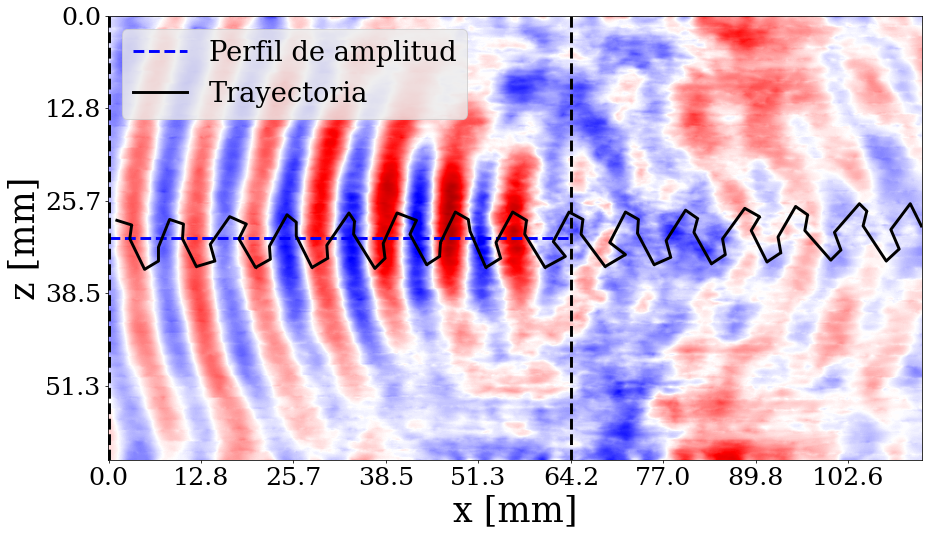

In [28]:
# Aca visualizamos la deformación y la linea que vamos a estudiar para la amplitud
fig,ax = plt.subplots()
im = ax.imshow(filter_map[i_frame], aspect='equal', cmap=cmap, norm = norm)
ax.plot(xs, line_amp,'--', label='Perfil de amplitud', lw=3, color='b')
ax.plot(x,y, '.-', color='k', ms=1, label='Trayectoria',lw=3)
ax.axvline(x_min, ls='--', color='k',lw=3)
ax.axvline(x_max, ls='--', color='k',lw=3)

ax.set_ylabel('z [mm]')
ax.set_xlabel('x [mm]')
ax.legend(loc='upper left')
plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.xticks()[0][1:-1]])
plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.yticks()[0][1:-1]])
[]

La longitud de onda promedio es:  8.789106241081202  \pm  0.23180448023704717 mm
La longitud de onda promedio es:  68.5  \pm  1.8066236157232305 px


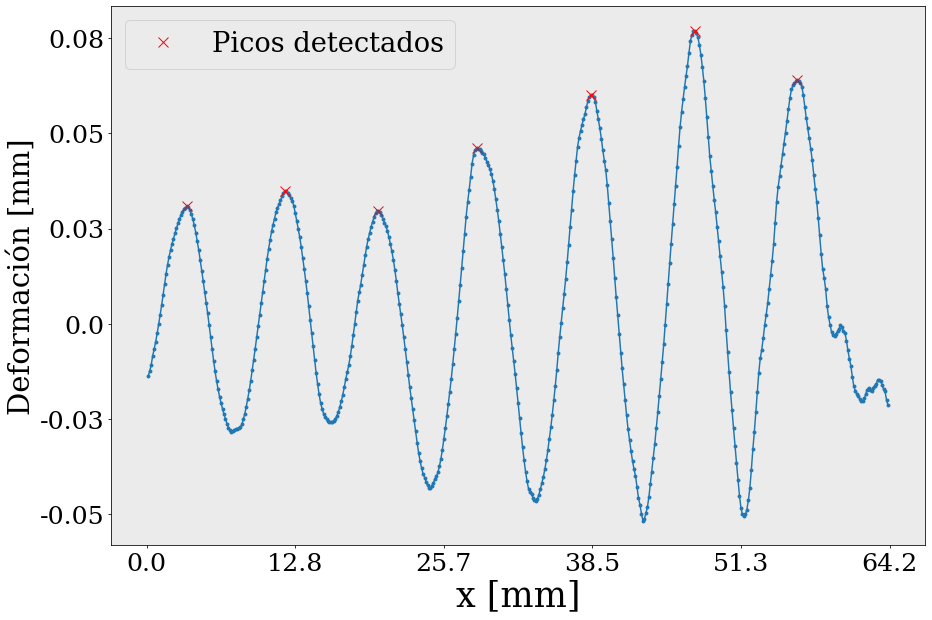

In [30]:
# A partir del perfil de amplitud seleccionado detectamos los picos y con ellos calculamos la longitud de onda de la amplitud
pk_l = find_peaks(filter_frame, width=[10,100], distance=15)[0]

lambs = np.diff(xs[pk_l]/PX_PER_MM)
l_mean = np.mean(lambs)
l_std = np.std(np.diff(xs[pk_l]/PX_PER_MM))/np.sqrt(len(lambs))

fig,ax = plt.subplots()
ax.plot(xs, filter_frame,'.-')
ax.set_xlabel('x [mm]')
ax.set_ylabel('Deformación [mm]', fontsize=30)
ax.plot(xs[pk_l], filter_frame[pk_l], 'x', ms=10, color='r', label='Picos detectados')
plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),1)) for i in plt.xticks()[0][1:-1]])
plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [str(np.round(i/(PX_PER_MM),2)) for i in plt.yticks()[0][1:-1]])
ax.legend()

print("La longitud de onda promedio es: ",l_mean," \pm ",l_std,"mm")
print("La longitud de onda promedio es: ",l_mean*PX_PER_MM," \pm ",l_std*PX_PER_MM,"px")